# Система рекомендаций игр


**Цель исследования - ответить на вопросы и посчитать матрицу косинуса схожести.**

**Вопросы:**
1. На какой платформе вышло больше всего игр?
2. Сколько эксклюзивных игр вышло от разных платформодержателей?
3. У какой компании самые высокооцененные игры?
4. Какие самые высокооцененные игры в каждой компании?

**Ход исследования**

Для проведения исследования доступны данные:
- game_cards.csv - данные об играх за период 1993-2023 годах, информация с сайта metacritic.com

Перед решением задачи понадобится обзор данных. Затем на этапе предобработки данных исправим найденные ошибки.

На этапе исследования данных дадим ответы на вопросы. Затем посчитаем матрицу косинуса схожести по описанию игр.

Этапы исследования
1. Обзор данных.
2. Предобработка данных.
3. Исследование данных.
4. Построение матрицы косинуса схожести.
5. Выводы.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Обзор данных

In [2]:
# читаем данные с файла и сохраняем в переменную
df = pd.read_csv('game_cards.csv')

In [3]:
# выводим первые 5 строк
df.head()

,name,platform,date,summary,metascore,userscore,href
0,Sid Meier s Civilization II,PC,"February 29, 1996",An empire-building turn-based strategy game. T...,94,8.8,/game/pc/sid-meiers-civilization-ii
1,Quake,PC,"June 22, 1996",Rage through 32 single player levels and 6 dea...,94,8.7,/game/pc/quake
2,Diablo,PC,"December 31, 1996",The kingdom of Khandaras has fallen into chaos...,94,8.6,/game/pc/diablo
3,Super Mario 64,Nintendo 64,"September 26, 1996",Mario is super in a whole new way! Combining t...,94,9.1,/game/nintendo-64/super-mario-64
4,Wipeout XL,PlayStation,"September 30, 1996",The original scorched the game world and becam...,93,8.6,/game/playstation/wipeout-xl


Каждая строка это описание одной игры.

Описание колонок:
- `name` - название игры
- `platform` - система на которой вышла игра
- `date` - дата выхода игры
- `summary` - описание
- `metascore` - средняя оценка от критиков
- `userscore` - средняя оценка от игроков
- `href` - гиперссылка на страничку игры

In [4]:
# посмотрим на общую информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19837 entries, 0 to 19836
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       19837 non-null  object
 1   platform   19837 non-null  object
 2   date       19837 non-null  object
 3   summary    19742 non-null  object
 4   metascore  19837 non-null  int64 
 5   userscore  19837 non-null  object
 6   href       19837 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.1+ MB


- всего доступно 19837 строк
- в колонке `summary` присутствуют пропуски
- колонка `date` имеет несоответствие типа данных, нужно `object` заменить на `datetime`
- колонка `userscore` имеет несоответствие типа данных, нужно `object` заменить на `float`

#### Вывод

Для анализа доступно 19837 строк с данными об играх.

Есть чуть меньше 100 пропущенных значений в колонке `summary`.

Колонки `date` и `userscore` имеют неправильный тип данных.

# Предобработка данных

### Изменение типа данных в колонке `date`

In [5]:
df['date'] = pd.to_datetime(df['date'])

### Изменение типа данных в колонке `userscore`

In [6]:
# посмотрим количество значений, которые
# не являются числовыми
no_score = df['userscore'].str.replace('.', '').str.isnumeric() == False

print(f'Всего {no_score.sum()} игр не имеют оценок от пользователей')

Всего 1420 игр не имеют оценок от пользователей


In [7]:
# посмотрим на эти игры подробнее
df[no_score].sample(10)

,name,platform,date,summary,metascore,userscore,href
14907,Toby: The Secret Mine,PlayStation 4,2017-07-06,Get lost in the shadows and pray you find your...,50,tbd,/game/playstation-4/toby-the-secret-mine
3299,Rapala Pro Fishing,Xbox,2004-08-31,"Grab your tackle box, launch the bass boat and...",59,tbd,/game/xbox/rapala-pro-fishing
4668,Laserlife,PlayStation 4,2015-09-22,Laserlife is an interactive biography focusing...,65,tbd,/game/playstation-4/laserlife
5081,Moscow to Berlin: Red Siege,PC,2006-06-14,Moscow to Berlin follows in the footsteps Dese...,57,tbd,/game/pc/moscow-to-berlin-red-siege
5767,Zendoku,DS,2007-06-26,ZENDOKU blends exciting puzzle battle action w...,68,tbd,/game/ds/zendoku
361,F1 Championship Season 2000,PlayStation 2,2000-12-19,F1 Championship Season 2000 may not be the dee...,71,tbd,/game/playstation-2/f1-championship-season-2000
8495,Bejeweled Twist,DS,2010-01-18,Spin and match explosive gems for shockwaves o...,77,tbd,/game/ds/bejeweled-twist
18475,Astrologaster,Switch,2021-02-18,Play as ‘Doctor’ Simon Forman - unlicensed med...,79,tbd,/game/switch/astrologaster
7733,Space Bust-A-Move,DS,2009-07-28,"(Also known as ""Puzzle Bobble Galaxy"") The sma...",71,tbd,/game/ds/space-bust-a-move
9696,Ghost Mania,Wii,2011-01-03,Ghost Mania is an original puzzle game for pla...,57,tbd,/game/wii/ghost-mania


Эти игры имеют статус `tbd` что расшифровывается как `to be determined`. Этот статус означает что игра имеет меньше 3-х оценок.

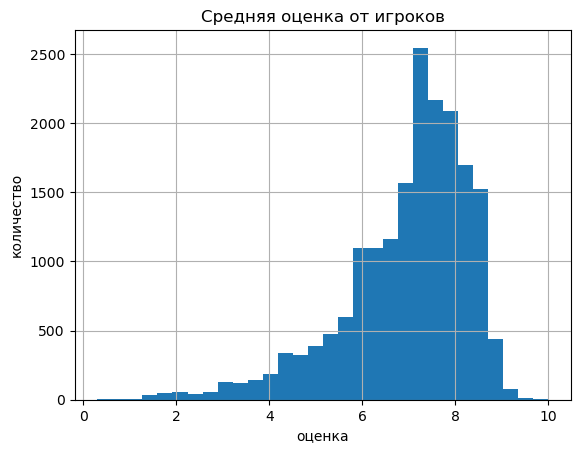

In [8]:
# для начала заменим тип данных 
# там где есть оценка и 
# посмотрим на гистограмму

df2 = df.copy()

df2['userscore'] = df2[no_score == False]['userscore'].astype('float64')

df2['userscore'].hist(bins=30)

plt.title('Средняя оценка от игроков')
plt.xlabel('оценка')
plt.ylabel('количество')

plt.show()

Гистограмма имеет длинный левый хвост из-за которого среднее значение смещено.

Есть два варианта действия:
1. Заменить пропущенные значения медианной
2. Заменить пропущенные значения оценкой от критиков деленная на 10

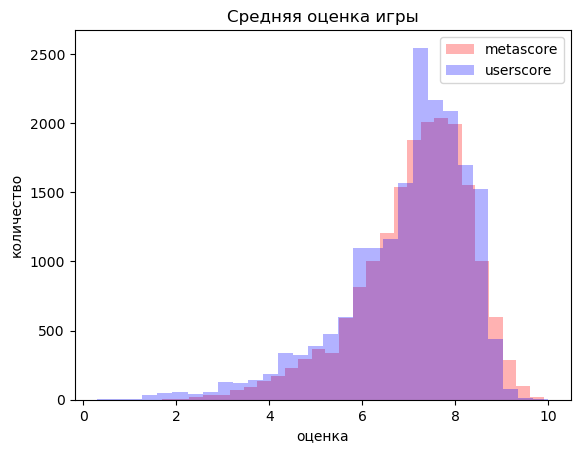

In [9]:
# посмотрим на второй вариант

# посторим гистограмму оценкок от
# критиков и пользователей

fig, ax = plt.subplots()

# оценка от критиков измеряется
# от 0 до 100, от игроков от 0 до 10
metascore = df2[df2['userscore'].notna()]['metascore'] / 10
userscore = df2[df2['userscore'].notna()]['userscore']

bins = 30
alpha = 0.3

ax.hist(metascore, bins=bins, color='red', alpha=alpha, label='metascore')
ax.hist(userscore, bins=bins, color='blue', alpha=alpha, label='userscore')

plt.title('Средняя оценка игры')
plt.xlabel('оценка')
plt.ylabel('количество')

plt.legend()

plt.show()

На графике видно, что критики более смело ставят оценки близкие к максимальным (правый хвост) и меньше минимальных (левый хвост). Игроки в свою очередь реже радуют разработчиков и издателей максимальными оценками и чаще ставят минимальные. Возможно это связано с разницей в градациях оценок. У игроков их 10 (от 0 до 10), у критиков 100 (от 0 до 100).

In [10]:
# посмотрим на среднее и медиану
df2[df2['userscore'].notna()].describe()

,metascore,userscore
count,18417.000000,18417.000000
mean,71.237824,6.970522
std,12.184164,1.353963
min,11.000000,0.300000
25%,65.000000,6.300000
50%,73.000000,7.300000
75%,80.000000,7.900000
max,99.000000,10.000000


(если поделить `metascore` на 10)

- медиана у критиков и игроков совпадает (7.3)
- среднее значение немного отличается (7.12 против 6.97)

##### Заменим `tbd` в колонке `userscore` на оценки от критиков деленные на 10

In [11]:
df.loc[df['userscore'] == 'tbd', 'userscore'] = df.loc[df['userscore'] == 'tbd', 'metascore'] / 10

# проверка
df[df['userscore'] == 'tbd']

,name,platform,date,summary,metascore,userscore,href


In [12]:
# изменим тип данных object на float
df['userscore'] = df['userscore'].astype('float64')

df['userscore'].dtypes

dtype('float64')

### Пропуски в колонке `summary`

In [13]:
df['summary'].isna().sum()

95

Заменить пропуски нечем, количество их очень мало, поэтому просто удалим их.

In [14]:
df.dropna(subset=['summary'], inplace=True)

df['summary'].isna().sum()

0

### Обработка дубликатов

In [15]:
df.duplicated().sum()

0

Дубликаты строк отсутствуют. Проверим дубликат по названию игр.

In [16]:
df['name'].duplicated().sum()

6992

Всего в данных 6992 дубликатов. Это обусловлено тем, что одна игра может выходить на несколько платформ. 

Дубликаты можно просто удалить. Я же хочу написать функцию, которая будет оставлять копию с самой высокой оценкой, а все остальные удалять.

In [17]:
def delete_duplicate(df):
    duplicated_name = df[df['name'].duplicated()]['name'].unique()
    drop_list = np.array([])
    for name in duplicated_name:
        drop_href = (df[df['name'] == name]
                         .sort_values(by=['metascore', 'userscore'], 
                                        ascending=False)['href'].values[1:])
        drop_list = np.append(drop_list, drop_href)

    return df[~df['href'].isin(drop_list)].reset_index(drop=True)

In [18]:
df = delete_duplicate(df)

df['name'].duplicated().sum()

0

#### Вывод

На этапе предобработки данных мы заменили значения `tbd` в колонке `userscore` на оценки критиков делённые на 10 и изменили тип данных на `float64`, изменили тип колонки `date` на `datetime`, удалили пропуски в колонке `summary` и удалили дубликаты игр. В таблице осталось 12749 строки.

# Исследование данных

### На какой платформе вышло больше всего игр?

In [19]:
# для ответа на этот вопрос
# нужно прочитать данные заново
# потому что ранее были удалены дубликаты

df2 = pd.read_csv('game_cards.csv')

In [20]:
df2.groupby('platform').count()['name'].sort_values(ascending=False)

platform
PC                  5214
PlayStation 4       2115
Xbox 360            1665
Switch              1648
PlayStation 2       1421
PlayStation 3       1265
Xbox One            1198
Xbox                 794
DS                   728
Wii                  663
PSP                  514
GameCube             452
Game Boy Advance     442
3DS                  398
PlayStation 5        295
PlayStation Vita     258
Xbox Series X        191
PlayStation          189
Wii U                186
Dreamcast            125
Nintendo 64           71
Stadia                 5
Name: name, dtype: int64

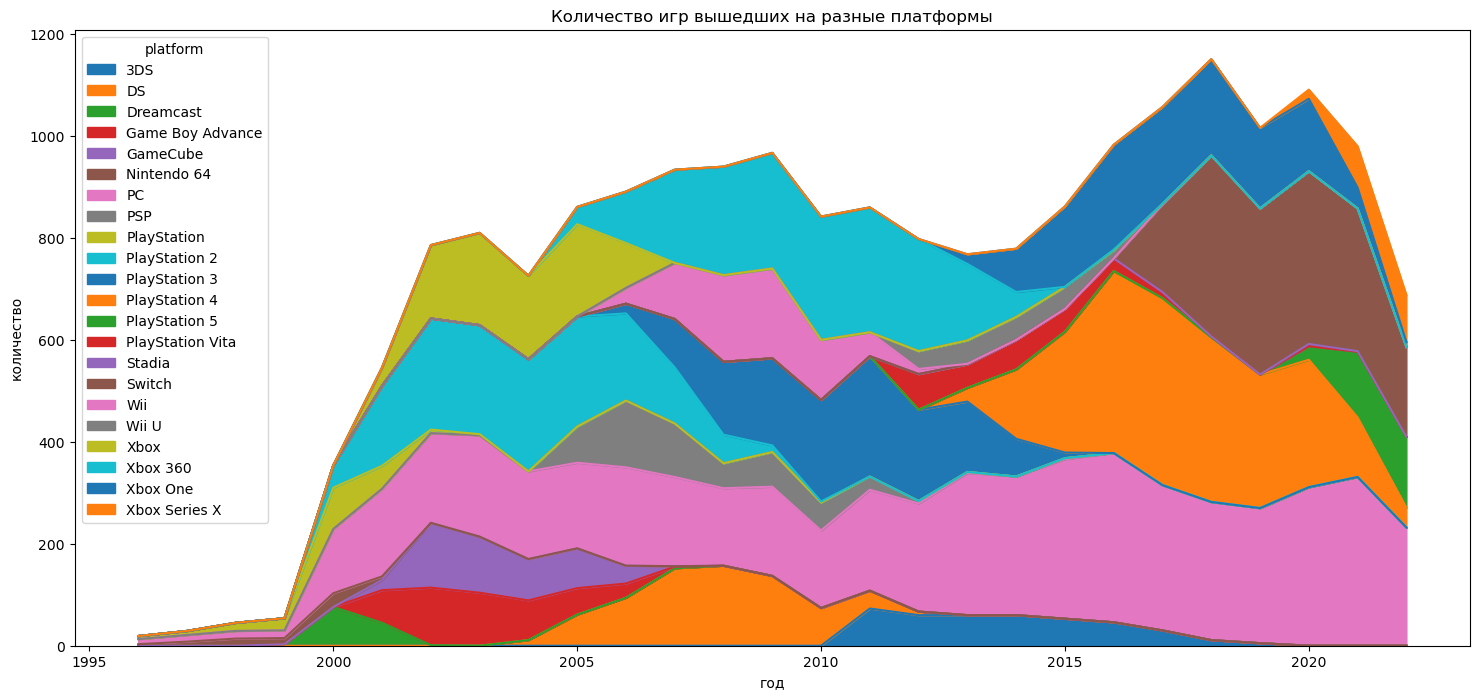

In [21]:
df2['date'] = pd.to_datetime(df2['date'])
df2['year'] = df2['date'].dt.year

pd.crosstab(index=df2['year'], columns=df2['platform']).plot(kind='area', figsize=(18, 8))

plt.title('Количество игр вышедших на разные платформы')
plt.xlabel('год')
plt.ylabel('количество')

plt.show()

Персональные компьютеры (розовая площадь) в лидерах с отрывом в 2.5 раза от Playstation 4 (5214 против 2115). Это можно объяснить тем, что консоли выпускаются раз в 8 лет (современные консоли) и под конец жизненного цикла игр выходи все меньше и меньше.

Попробуем объединить разные поколения консолей и посмотрим на результат.

In [22]:
company = {
    'Nintendo': [
        'Nintendo 64', 'DS', 'Game Boy Advance',
        'GameCube', 'Wii', '3DS', 'Switch',
        'Wii U'
    ],
    'Sony': [
        'PlayStation', 'PlayStation 2', 'PlayStation 4',
        'PlayStation Vita', 'PlayStation 3', 'PSP',
        'PlayStation 5'
    ],
    'Google': [
        'Stadia'
    ],
    'Microsoft': [
        'Xbox', 'Xbox 360', 'Xbox One', 'Xbox Series X'
    ],
    'Sega': [
        'Dreamcast',
    ]
}

df2['company'] = df2['platform']

for key, value in company.items():
    df2.loc[df2['company'].isin(value), 'company'] = key

In [23]:
df2.groupby('company').count()['name'].sort_values(ascending=False)

company
Sony         6057
PC           5214
Nintendo     4588
Microsoft    3848
Sega          125
Google          5
Name: name, dtype: int64

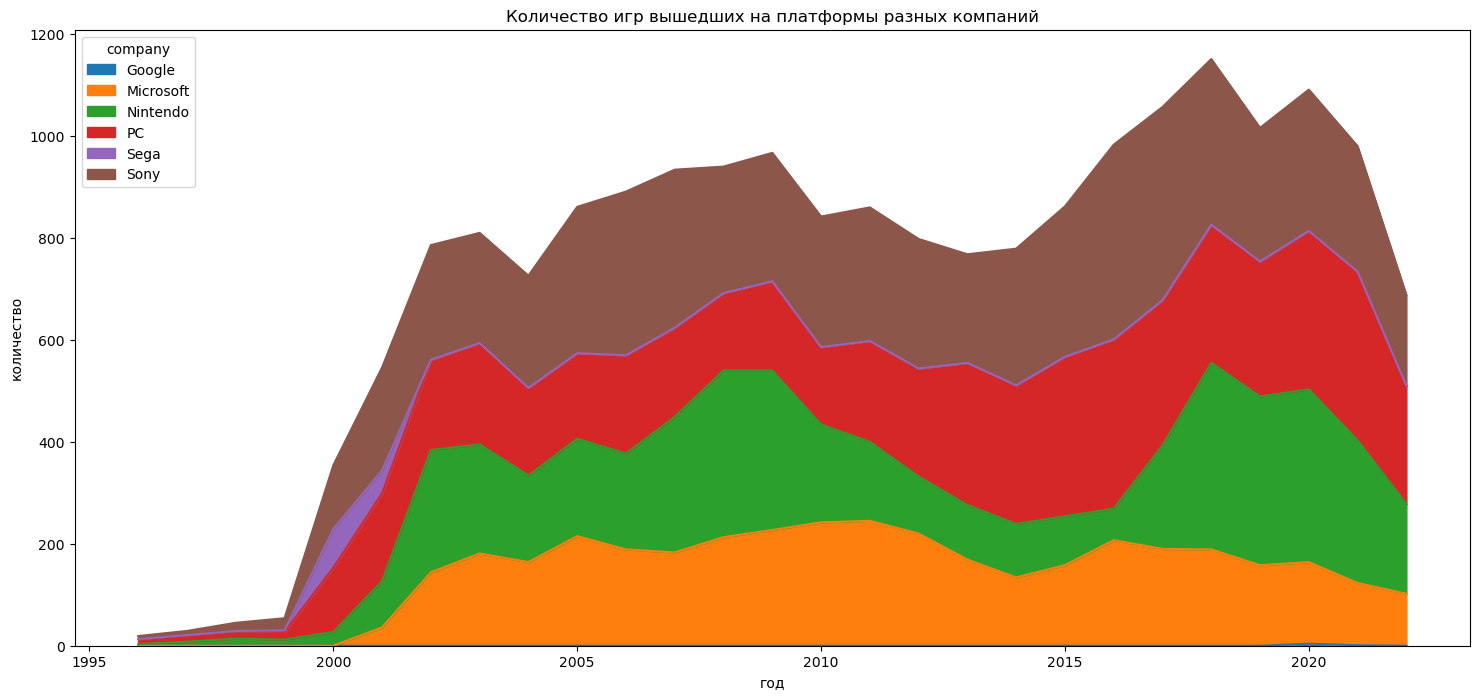

In [24]:
pd.crosstab(index=df2['year'], columns=df2['company']).plot(kind='area', figsize=(18, 8))

plt.title('Количество игр вышедших на платформы разных компаний')
plt.xlabel('год')
plt.ylabel('количество')

plt.show()

Ситуация изменилась. На игровые платформы от компании Sony вышло больше всего игр 6057, против 5214 на PC. Скорее это связано со стратегией эксклюзивности контента на консолях компании.

На графике можно заметить 2 локальных пика в 2008 и 2018. Плавный подьем компании Sony и резкий подьем компании Nintendo. 

В 2006 были выпущенны консоли 7-го поколения Playstation 3 от компании Sony и Wii от компании Nintendo.

В 2013 и 2017 были выпущенны консоли 8-го поколения Playstation 4 от компании Sony и Switch от компании Nintendo соответственно.

#### Вывод

В период с 1996 по 2022 годах на платформу от компании Sony вышло больше всего игр (6057). Немного отстает от первого места персональный компьютер (5214).

В 2008 и 2018 наблюдается 2 пиковых значения по количеству выходимых игр и последующие спады. Незадолго до этого выходили консоли нового поколения. Можно предположить, что новые проекты создаются и выпускаются в начале и середине жизненного цикла платформы. Далее уже разрабатываются игры под новые поколения.

### Сколько эксклюзивных игр вышло от разных платформодержателей?

In [25]:
# возьмем множество игр компании и отнимим
# множество игр остальных компаний,
# разница даст нам уникальные значения
# которые выпустила только эта компания

exclusive_games = {}
for key, _ in company.items():
    qty_exclusive_games = set(df2[df2['company'] == key]['name']) - set(df2[df2['company'] != key]['name'])
    exclusive_games[key] = list(qty_exclusive_games)
    
    print(f'Компания {key} выпустила {len(qty_exclusive_games)} эксклюзивных игр')

Компания Nintendo выпустила 2675 эксклюзивных игр
Компания Sony выпустила 2323 эксклюзивных игр
Компания Google выпустила 4 эксклюзивных игр
Компания Microsoft выпустила 943 эксклюзивных игр
Компания Sega выпустила 76 эксклюзивных игр


In [26]:
# создадим категориальную колонку
# с индикатором эксклюзивности для каждой компании
df2['exclusive'] = ['multiplatform'] * df2.shape[0]

for key, value in exclusive_games.items():
    df2.loc[df2['name'].isin(value), 'exclusive'] = f'{key.lower()}_exclusive'

In [27]:
# создадим сводную таблицу
# с суммой эклюзивов и мультиплатформы от компаний
pt = pd.pivot_table(data=df2,
                    index='company', 
                    columns='exclusive', 
                    values='name', 
                    aggfunc='count').reset_index()

pt

exclusive,company,google_exclusive,microsoft_exclusive,multiplatform,nintendo_exclusive,sega_exclusive,sony_exclusive
0,Google,4.0,NaN,1.0,NaN,NaN,NaN
1,Microsoft,NaN,945.0,2903.0,NaN,NaN,NaN
2,Nintendo,NaN,NaN,1839.0,2749.0,NaN,NaN
3,PC,NaN,NaN,5214.0,NaN,NaN,NaN
4,Sega,NaN,NaN,49.0,NaN,76.0,NaN
5,Sony,NaN,NaN,3618.0,NaN,NaN,2439.0


In [28]:
# удалим названия компаний из названия колонок
pt.columns = [i.split('_')[-1] for i in pt.columns]

# создадим колонку `exc` и запишем туда количесво эксклюзивных игр
for i in pt['company']:
    pt.loc[pt['company'] == i, 'exc'] = pt.loc[pt['company'] == i, 'exclusive'].fillna(0).values.sum()

# удалим колонки с названием `exclusive` и 
# переименуем `exc` в `exclusive`
pt.drop('exclusive', axis=1, inplace=True)
pt.rename(columns={'exc': 'exclusive'}, inplace=True)

pt

,company,multiplatform,exclusive
0,Google,1.0,4.0
1,Microsoft,2903.0,945.0
2,Nintendo,1839.0,2749.0
3,PC,5214.0,0.0
4,Sega,49.0,76.0
5,Sony,3618.0,2439.0


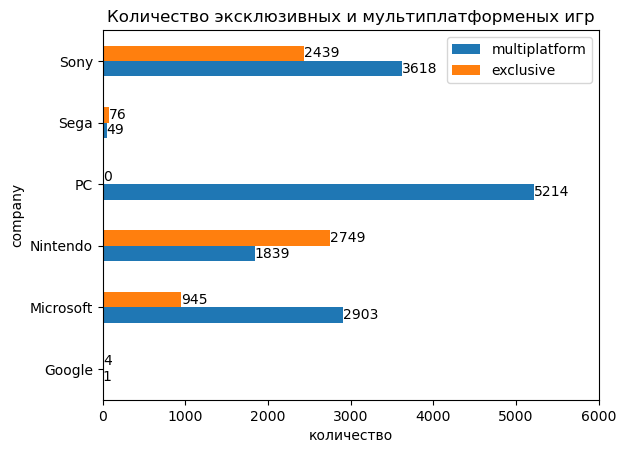

In [29]:
fig, ax = plt.subplots()

ax = pt.plot(ax=ax, kind='barh', x='company') 

for container in ax.containers:
    ax.bar_label(container)

ax.set_xlim(0, 6000)
    
plt.title('Количество эксклюзивных и мультиплатформеных игр')
plt.xlabel('количество')

plt.show()

Количество эксклюзивов на графике и в начале темы отличается. Это из-за того, что компания может выпустить одну игру на несколько своих платформ. Например, игра `GoldenEye 007` от Nintendo выходила на консоли `Nintendo 64`, `Wii`, `DS`.

##### Вывод

В период с 1996 по 2022 годах на консоли Nintendo вышло больше всего эксклюзивных игр (2749) и в тоже время меньше всего мультиплатформенных игр. Связано это с тем, что Nintendo выпускает слабые консоли относительно конкурентов и разработчикам сложно портировать свои игры.

Компания Sony на втором месте с результатом 2439.

Меньше всех, из большой тройки, вышло эксклюзивов на консоли от Microsoft (945).

### У какой компании самые высокооцененные игры?

In [30]:
# изменим тип данных
# в колонке userscore

df2.loc[df2['userscore'] == 'tbd', 'userscore'] = df2.loc[df2['userscore'] == 'tbd', 'metascore'] / 10
df2['userscore'] = df2['userscore'].astype('float64')

In [31]:
# посмотрим среднее значение эксклюзивных игр
df2[df2['exclusive'] != 'multiplatform'].groupby('exclusive') \
                                        .agg(['mean'])[['metascore', 'userscore']]

,metascore,userscore
,mean,mean
exclusive,,
google_exclusive,69.250000,6.850000
microsoft_exclusive,65.744974,6.686455
nintendo_exclusive,69.165879,7.152310
sega_exclusive,74.407895,7.893421
sony_exclusive,69.063141,7.097458


(небольшое количество от google и sega не учитываются)

Игры от компании Nintendo обладают самой высокой оценкой от критиков и игроков. Компания Sony совсем немного отстает от первого места. У Microsoft оценки сильно хуже в сравнении с конкурентами.

In [32]:
# посмотрим оценки по годам

# поделим оценки критиков на 10, для 
df2['metascore'] = df2['metascore'] / 10

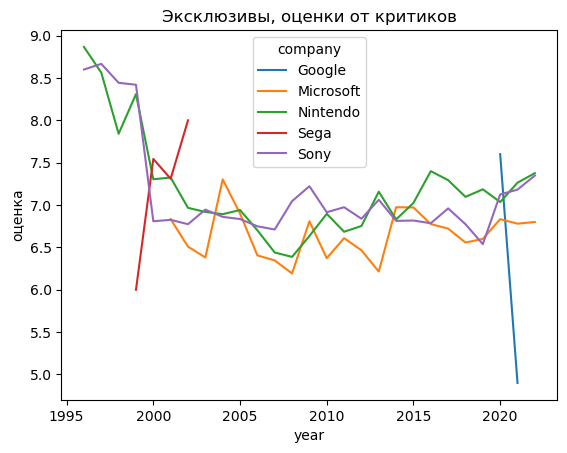

In [43]:
# эксклюзивы, оценки критиков
pd.pivot_table(data=df2[df2['exclusive'] != 'multiplatform'], \
               index='company', \
               columns='year', \
               values='metascore', \
               aggfunc='mean').T.plot()

plt.title('Эксклюзивы, оценки от критиков')
plt.ylabel('оценка')

plt.show()

За весь период компании Sony и Nintendo делят первое и второе место и лишь однажды в 2004 году компания Microsoft получила более высокие оценки от критиков.

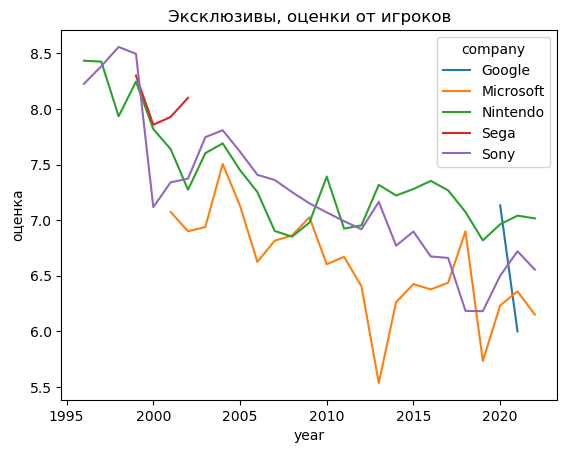

In [44]:
# эксклюзивы, оценки игроков
pd.pivot_table(data=df2[df2['exclusive'] != 'multiplatform'], \
               index='company', \
               columns='year', \
               values='userscore', \
               aggfunc='mean').T.plot()

plt.title('Эксклюзивы, оценки от игроков')
plt.ylabel('оценка')

plt.show()

Если до 2010 года компания Microsoft получала примерно такие же балы как у конкурентов, то после 2010 ситуация ухудшилась. 
После 2013 года компания Nintendo выбилась в лидеры и держится там по сей день. Чего не скажешь про Sony, чей бал 
примерно в тот период начал падать.

Начиная с 1996 средний бал от игроков падает каждый год. 

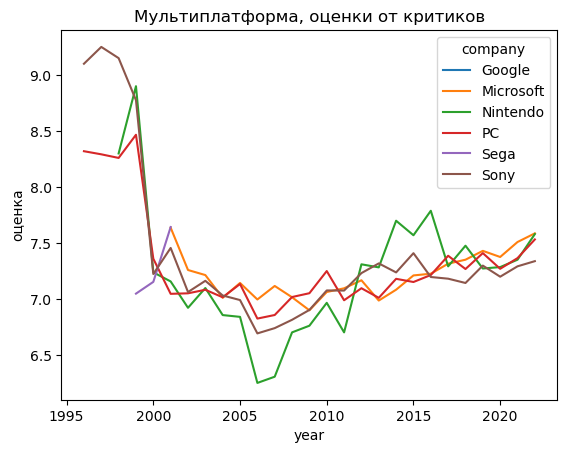

In [45]:
# мультиплатформа, оценки критиков
pd.pivot_table(data=df2[df2['exclusive'] == 'multiplatform'], \
               index='company', \
               columns='year', \
               values='metascore', \
               aggfunc='mean').T.plot()

plt.title('Мультиплатформа, оценки от критиков')
plt.ylabel('оценка')

plt.show()

Ситуация с мультиплатформой и оценками от критиков примерно одинаковая у Sony и Microsoft, по мощности они выпускают одинаковое железо. 

Чего не скажешь про компанию Nintendo. В период 2005-2010 средняя оценка сильно упала. И напротив в период 2014-2016 сильно выросла.

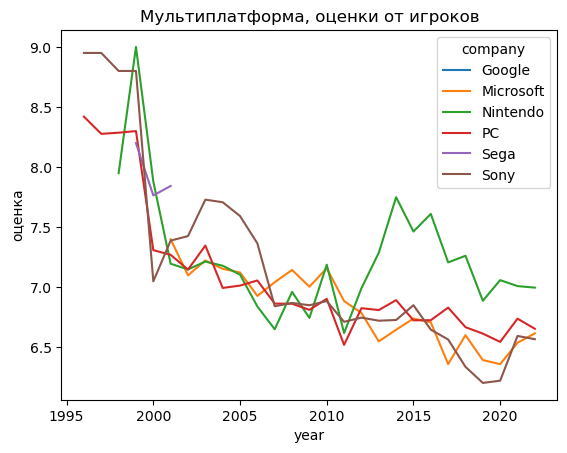

In [46]:
# мультиплатформа, оценки игроков
pd.pivot_table(data=df2[df2['exclusive'] == 'multiplatform'], \
               index='company', \
               columns='year', \
               values='userscore', \
               aggfunc='mean').T.plot()

plt.title('Мультиплатформа, оценки от игроков')
plt.ylabel('оценка')

plt.show()

Оценки от пользователей показывают другую картину:

- в период 2001-2005 компания Sony была сильно впереди конкурентов, которые делили второе место
- в период 2012 компания Nintendo вырвалась сильно вперед и остается там по сей день

Оценки от пользователей показывают отрицательную линейную связь, то есть с каждым годом падаю.

#### Вывод

Игры от компании Nintendo обладают самой высокой оценкой от критиков (69.17) и игроков (7.15). Компания Sony совсем немного отстает от первого места (69.06 и 7.1). У Microsoft оценки сильно хуже в сравнении с конкурентами (65.74 и 6.69). Начиная с 1996 средний бал от игроков показывает отрицательную линейную связь, то есть с каждым годом падаю.

### Какие самые высокооцененные игры в каждой компании?

In [37]:
# по версии критиков
for c in df2['company'].unique():
    if c == 'PC':
        continue
    
    df_filter = df2[(df2['exclusive'] != 'multiplatform') & (df2['company'] == c)]
    max_score = df_filter['metascore'].max()
    display(df_filter[df_filter['metascore'] == max_score])

,name,platform,date,summary,metascore,userscore,href,year,company,exclusive
50,The Legend of Zelda: Ocarina of Time,Nintendo 64,1998-11-23,"As a young boy, Link is tricked by Ganondorf, ...",9.9,9.1,/game/nintendo-64/the-legend-of-zelda-ocarina-...,1998,Nintendo,nintendo_exclusive


,name,platform,date,summary,metascore,userscore,href,year,company,exclusive
51,Tekken 3,PlayStation,1998-04-29,"An ancient evil force has reawakened, attackin...",9.6,9.0,/game/playstation/tekken-3,1998,Sony,sony_exclusive
53,Gran Turismo,PlayStation,1998-04-30,Welcome to the most advanced racing game ever ...,9.6,8.6,/game/playstation/gran-turismo,1998,Sony,sony_exclusive
506,Metal Gear Solid 2: Sons of Liberty,PlayStation 2,2001-11-12,"Since the incident on Shadow Moses Island, Met...",9.6,8.8,/game/playstation-2/metal-gear-solid-2-sons-of...,2001,Sony,sony_exclusive
7243,Uncharted 2: Among Thieves,PlayStation 3,2009-10-13,Fortune hunter Nathan Drake returns in Unchart...,9.6,8.8,/game/playstation-3/uncharted-2-among-thieves,2009,Sony,sony_exclusive


,name,platform,date,summary,metascore,userscore,href,year,company,exclusive
54,NFL 2K1,Dreamcast,2000-09-07,"In the end, NFL 2K1 is a deeper, more refined ...",9.7,6.2,/game/dreamcast/nfl-2k1,2000,Sega,sega_exclusive


,name,platform,date,summary,metascore,userscore,href,year,company,exclusive
1857,Grand Theft Auto Double Pack,Xbox,2003-10-31,From the dark and seedy streets of Liberty Cit...,9.6,8.1,/game/xbox/grand-theft-auto-double-pack,2003,Microsoft,microsoft_exclusive


,name,platform,date,summary,metascore,userscore,href,year,company,exclusive
17291,Get Packed,Stadia,2020-04-28,Get Packed is a couch co-op removals game with...,8.1,7.7,/game/stadia/get-packed,2020,Google,google_exclusive


In [38]:
# по версии игроков
for c in df2['company'].unique():
    if c == 'PC':
        continue
    
    df_filter = df2[(df2['exclusive'] != 'multiplatform') & (df2['company'] == c)]
    max_score = df_filter['userscore'].max()
    display(df_filter[df_filter['userscore'] == max_score])

,name,platform,date,summary,metascore,userscore,href,year,company,exclusive
9135,Ghost Trick: Phantom Detective,DS,2011-01-11,Ghost Trick is a story of mystery and intrigue...,8.3,9.7,/game/ds/ghost-trick-phantom-detective,2011,Nintendo,nintendo_exclusive


,name,platform,date,summary,metascore,userscore,href,year,company,exclusive
8384,Z.H.P. Unlosing Ranger vs Darkdeath Evilman,PSP,2010-10-25,"Known as ZettaiHero Keikakuin Japan, Z.H.P. is...",8.1,9.7,/game/psp/zhp-unlosing-ranger-vs-darkdeath-evi...,2010,Sony,sony_exclusive


,name,platform,date,summary,metascore,userscore,href,year,company,exclusive
158,Resident Evil Code: Veronica,Dreamcast,2000-02-29,Resident Evil Code: Veronica takes up the stor...,9.4,9.4,/game/dreamcast/resident-evil-code-veronica,2000,Sega,sega_exclusive


,name,platform,date,summary,metascore,userscore,href,year,company,exclusive
14971,NieR: Automata - Become as Gods Edition,Xbox One,2018-06-26,NieR: Automata is an action RPG set in a post-...,9.0,9.1,/game/xbox-one/nier-automata---become-as-gods-...,2018,Microsoft,microsoft_exclusive


,name,platform,date,summary,metascore,userscore,href,year,company,exclusive
17291,Get Packed,Stadia,2020-04-28,Get Packed is a couch co-op removals game with...,8.1,7.7,/game/stadia/get-packed,2020,Google,google_exclusive


#### Вывод

Самыми высокооцененными играми от разных компаний являются:
1. У компании Nintendo по версии критиков это `The Legend of Zelda: Ocarina of Time` с оценкой 99, по версии игроков `Ghost Trick: Phantom Detective` с оценкой 9.7.
2. У компании Sony по версии критиков это `Tekken 3`, `Gran Turismo`, `Metal Gear Solid 2: Sons of Liberty` и `Uncharted 2: Among Thieves` с оценкой 96, по версии игроков `Z.H.P. Unlosing Ranger vs Darkdeath Evilman` с оценкой 9.7.
3. У компании Microsoft по версии критиков это `Grand Theft Auto Double Pack` с оценкой 96, по версии игроков `NieR: Automata - Become as Gods Edition` с оценкой 9.1.

# Построение матрицы косинуса схожести

In [39]:
# задаем алгорим Tfidf и устанавливаем
# удаление английских слова которые не несут в себе смысл
tfidf = TfidfVectorizer(stop_words='english')

# обучаем и сразу трансформируем описание игр
tfidf_matrix = tfidf.fit_transform(df['summary'])

# получаем матрицу из 12749 строк (описание) и 37975 столбцов (уникальные слова)
tfidf_matrix.shape

(12749, 37975)

In [40]:
# считаем косинус схожести матрицы tfid саму с собой
cos_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

cos_sim.shape

(12749, 12749)

Получаем матрицу 12749 на 12749 где каждое описание игры сравниваеть с каждым описанием игры. 

In [41]:
# сохраним в датафрей и выведем первые 5 строк
indices = pd.Series(df.index, index=df['name'])

cos_df = pd.DataFrame(cos_sim)

cos_df.columns = indices.index

cos_df['name'] = indices.index
cos_df = cos_df.set_index('name')

cos_df.head()

name,Sid Meier s Civilization II,Quake,Diablo,Super Mario 64,Wipeout XL,Wave Race 64,Tomb Raider,Resident Evil,Command & Conquer: Red Alert,Tekken 2,...,Dragon Ball: The Breakers,Blind Fate: Edo no Yami,In Nightmare,Blade Runner: Enhanced Edition,The Waylanders,Zorro: The Chronicles,Babylon s Fall,LEGO Brawls,CrossfireX,POSTAL 4: No Regerts
name,,,,,,,,,,,,,,,,,,,,,
Sid Meier s Civilization II,1.000000,0.000000,0.000000,0.012123,0.015086,0.000000,0.000000,0.00000,0.002820,0.018191,...,0.003491,0.030755,0.003360,0.012820,0.041158,0.055510,0.011883,0.006660,0.007078,0.007632
Quake,0.000000,1.000000,0.000000,0.019421,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.020987,0.000000,0.018753,0.000000,0.000000,0.000000,0.000000
Diablo,0.000000,0.000000,1.000000,0.010423,0.002848,0.003000,0.018034,0.00555,0.032526,0.000000,...,0.005745,0.030089,0.026324,0.013415,0.000000,0.030428,0.034835,0.001286,0.001892,0.012703
Super Mario 64,0.012123,0.019421,0.010423,1.000000,0.033848,0.055659,0.016809,0.00000,0.005226,0.008428,...,0.024262,0.015274,0.015912,0.031215,0.000000,0.002551,0.006100,0.021704,0.000000,0.005971
Wipeout XL,0.015086,0.000000,0.002848,0.033848,1.000000,0.014573,0.000000,0.00000,0.010206,0.010487,...,0.009253,0.019278,0.004567,0.022945,0.016755,0.003174,0.007591,0.002432,0.013059,0.009732


Например, игра `Sid Meier s Civilization II` похожа на саму себя на 1 , `Super Mario 64` похож на `Sid Meier s Civilization II` на 0.012123.

In [42]:
# можно сохранить матрицу похожести в файл
# cos_df.to_pickle('cosine_similarity.pkl') # ~ 1.2 gb

#### Вывод

Мы посчитали матрицу косинуса схожести. Она нам понадобится для подальшего построения рекомендательной системы.

# Выводы

Для проведения исследования доступны данные 19837 игр.

На этапе предобработки данных мы заменили значения `tbd` в колонке `userscore` на оценки критиков делённые на 10 и изменили тип данных на `float64`, изменили тип колонки `date` на `datetime`, удалили пропуски в колонке `summary` и удалили дубликаты игр. В таблице осталось 12749 строки.

**Анализ данных показал:**

1. В период с 1996 по 2022 годах на платформу от компании Sony вышло больше всего игр (6057). Немного отстает от первого места персональный компьютер (5214). В 2008 и 2018 наблюдается 2 пиковых значения по количеству выходимых игр и последующие спады. Незадолго до этого выходили консоли нового поколения. Можно предположить, что новые проекты создаются и выпускаются в начале и середине жизненного цикла платформы. Далее уже разрабатываются игры под новые поколения.

2. В период с 1996 по 2022 годах на консоли Nintendo вышло больше всего эксклюзивных игр (2749) и в тоже время меньше всего мультиплатформенных игр. Связано это с тем, что Nintendo выпускает слабые консоли относительно конкурентов и разработчикам сложно портировать свои игры. Компания Sony на втором месте с результатом 2439. Меньше всех, из большой тройки, вышло эксклюзивов на консоли от Microsoft (945).

3. Игры от компании Nintendo обладают самой высокой оценкой от критиков (69.17) и игроков (7.15). Компания Sony совсем немного отстает от первого места (69.06 и 7.1). У Microsoft оценки сильно хуже в сравнении с конкурентами (65.74 и 6.69). Начиная с 1996 средний бал от игроков показывает отрицательную линейную связь, то есть с каждым годом падаю.

4. Самые высокооцененные игры: 
    - у компании Nintendo по версии критиков это `The Legend of Zelda: Ocarina of Time` с оценкой 99, по версии игроков `Ghost Trick: Phantom Detective` с оценкой 9.7
    - у компании Sony по версии критиков это `Tekken 3`, `Gran Turismo`, `Metal Gear Solid 2: Sons of Liberty` и `Uncharted 2: Among Thieves` с оценкой 96, по версии игроков `Z.H.P. Unlosing Ranger vs Darkdeath Evilman` с оценкой 9.7
    - у компании Microsoft по версии критиков это `Grand Theft Auto Double Pack` с оценкой 96, по версии игроков `NieR: Automata - Become as Gods Edition` с оценкой 9.1


На основе данных мы посчитали меру сходства игр и сохранили в файл `cosine_similarity.pkl`.  

Для построения рекомендательной системы возьмем гармоническое среднее от меры сходства, оценки от критиков и игроков (предварительно нормализовав их). 

Эта система может быть полезна для поиска похожих игр.